In [1]:
import argparse
import os
import pickle
import re
from pathlib import Path
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from skimage.util import img_as_ubyte

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#modules from movement
#load poses data
from movement.io import load_poses
from movement.io import save_poses

#Filter and interpolate related
from movement.filtering import filter_by_confidence, interpolate_over_time
import movement.kinematics as kin
from movement.filtering import (
    interpolate_over_time,
    median_filter,
    savgol_filter,
)
from movement.utils.vector import compute_norm

from matplotlib import pyplot as plt

from movement import sample_data
from movement.io import load_poses
from movement.io import load_bboxes

import xarray as xr
import scipy.signal 


SHA256 hash of downloaded file: 40a6d79722dcaf7cee39627959e46a1bc10a6e1405842a7c2993d6d69b4c8195
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [4]:
import social_int_analyses
from social_int_analyses.path_dict_esay import path_dictionary as path_dict
from social_int_analyses.social_int_sess_deets import social_2P_sessions
from social_int_analyses.social_int_sess_deets import social_mice

In [51]:
social_mice

('social-0914-1', 'social-0914-4', 'social-0921-2')

In [67]:
speed_threshold = 250
mouse = 'social-0914-4'

def count_nans_by_keypoint(position):
    # Count number of NaNs for each keypoint (assumes position has shape [frames, individuals, keypoints, 2])
    return np.isnan(position).any(axis=-1).sum(axis=0)  # shape: [individuals, keypoints]

def run_movement(social_mice, social_2P_sessions):

    all_nan_counts = {}
    # for mouse in social_mice:
    nan_df = pd.DataFrame()
    for day in range(18):

        d = social_2P_sessions[mouse][day]
        date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
        h5_path = os.path.join('Z://giocomo/esay/cd_project/social_interaction/SLEAPData', mouse,  date, f'{scene}.h5')
        save_path = os.path.join('Z://giocomo/esay/cd_project/social_interaction/SLEAPData/movement', mouse,  date, f'{scene}.h5')
        print("Loading:", h5_path)

        if 'Env1' in scene:
            continue
        elif 'empty' in scene:
            continue
        else:
            ds_mouse = load_poses.from_sleap_file(h5_path, fps=30)

            original_nans = count_nans_by_keypoint(ds_mouse.position)
            original_nans_flat = original_nans.values.flatten()
        
            ds_mouse.update({"position": filter_by_confidence(ds_mouse.position, ds_mouse.confidence, threshold=0.5)})
            post_conf_nans = count_nans_by_keypoint(ds_mouse.position).values.flatten()

            ds_mouse["speed"] = kin.compute_speed(ds_mouse.position)

            
            threshold = speed_threshold # based on the
            speed_mouse_mask = ds_mouse["speed"] > threshold
            expanded_mouse_mask = speed_mouse_mask
            for i in range(len(speed_mouse_mask)):
                if speed_mouse_mask[i].any():
                    expanded_mouse_mask[i-1] = True
                        #expanded_mask[i] = True
                        #if i<(len(speed_mouse_mask)-1):
                        #    expanded_mouse_mask[i+1] = True
            ds_mouse["position"] = xr.where(expanded_mouse_mask, np.nan, ds_mouse["position"])
            post_speed_nans = count_nans_by_keypoint(ds_mouse.position).values.flatten()

            ds_mouse.update({"position": interpolate_over_time(ds_mouse.position, max_gap=40)})
            post_interp_nans = count_nans_by_keypoint(ds_mouse.position).values.flatten()


            # Build a DataFrame row
            num_keypoints = ds_mouse.position.shape[2]
            keypoint_labels = [f"{i}" for i in range(original_nans.shape[0])]  # one per individual
            flat_keys = [f"{kpt}_{kp}" for kpt in keypoint_labels for kp in ds_mouse.keypoints]

            nan_df = pd.concat([
                nan_df,
                pd.DataFrame({
                    'mouse': mouse,
                    'day': day,
                    'scene': scene,
                    'step': 'original',
                    **dict(zip(flat_keys, original_nans_flat))
                }, index=[0]),
                pd.DataFrame({
                    'mouse': mouse,
                    'day': day,
                    'scene': scene,
                    'step': 'post_confidence_threshold',
                    **dict(zip(flat_keys, post_conf_nans))
                }, index=[0]),
                pd.DataFrame({
                    'mouse': mouse,
                    'day': day,
                    'scene': scene,
                    'step': 'post_speed_threshold',
                    **dict(zip(flat_keys, post_speed_nans))
                }, index=[0]),
                pd.DataFrame({
                    'mouse': mouse,
                    'day': day,
                    'scene': scene,
                    'step': 'post_interpolation',
                    **dict(zip(flat_keys, post_interp_nans))
                }, index=[0])
            ], ignore_index=True)

            save_dir = os.path.dirname(save_path)
            os.makedirs(save_dir, exist_ok=True)
            save_poses.to_sleap_analysis_file(ds_mouse, save_path)

        all_nan_counts[mouse] = nan_df
    
    return all_nan_counts 

In [68]:
nan_df = run_movement('social-0914-4', social_2P_sessions)

Loading: Z://giocomo/esay/cd_project/social_interaction/SLEAPData\social-0914-4\03_10_2024\Env1_to_Env2_fixreward.h5
Loading: Z://giocomo/esay/cd_project/social_interaction/SLEAPData\social-0914-4\03_10_2024\social_emptytunnel.h5
Loading: Z://giocomo/esay/cd_project/social_interaction/SLEAPData\social-0914-4\03_10_2024\social_restrict_fam.h5

Missing points (marked as NaN) in input
	Individual: individual_0
		rightear: 2818/19388 (14.5%)
		tailbase: 4399/19388 (22.7%)
		nose: 5555/19388 (28.7%)
		head: 3870/19388 (20.0%)
		leftear: 3315/19388 (17.1%)
		torso: 2077/19388 (10.7%)

Missing points (marked as NaN) in output
	Individual: individual_0
		rightear: 7394/19388 (38.1%)
		tailbase: 8744/19388 (45.1%)
		nose: 13291/19388 (68.6%)
		head: 9839/19388 (50.7%)
		leftear: 6957/19388 (35.9%)
		torso: 10122/19388 (52.2%)

Missing points (marked as NaN) in input
	Individual: individual_0
		rightear: 7810/19388 (40.3%)
		tailbase: 8978/19388 (46.3%)
		nose: 13399/19388 (69.1%)
		head: 10148/

In [82]:
ds_mouse.position.shape

(16987, 2, 6, 1)

In [71]:
position = ds_mouse.position.sel(
    
    keypoints="nose"
)

In [20]:
ds_mouse = load_poses.from_sleap_file('Z://giocomo/esay/cd_project/social_interaction/SLEAPData/social-0914-1/03_10_2024/social_restrict_fam.h5', fps=30)


In [28]:
ds_mouse.position


<xarray.DataArray 'position' (time: 16987, space: 2, keypoints: 6,
                              individuals: 1)> Size: 815kB
nan nan nan nan nan nan nan nan ... 353.8 248.0 356.1 190.0 244.2 240.0 295.8
Coordinates:
  * time         (time) float64 136kB 0.0 0.03333 0.06667 ... 566.1 566.2 566.2
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'

In [4]:
ds_mouse.update({"position": filter_by_confidence(ds_mouse.position, ds_mouse.confidence, threshold=0.5)})



Missing points (marked as NaN) in input
	Individual: individual_0
		rightear: 3682/16987 (21.7%)
		tailbase: 5432/16987 (32.0%)
		nose: 4354/16987 (25.6%)
		head: 3498/16987 (20.6%)
		leftear: 3118/16987 (18.4%)
		torso: 1746/16987 (10.3%)

Missing points (marked as NaN) in output
	Individual: individual_0
		rightear: 8575/16987 (50.5%)
		tailbase: 10159/16987 (59.8%)
		nose: 11723/16987 (69.0%)
		head: 8864/16987 (52.2%)
		leftear: 6496/16987 (38.2%)
		torso: 8482/16987 (49.9%)


<xarray.Dataset> Size: 1MB
Dimensions:      (time: 16987, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 136kB 0.0 0.03333 0.06667 ... 566.1 566.2 566.2
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float32 815kB nan ... ...
    confidence   (time, keypoints, individuals) float32 408kB nan nan ... 0.8875
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/social_interaction/SLEAPData...
    ds_type:          poses

In [5]:
ds_mouse["speed"] = kin.compute_speed(ds_mouse.position)

In [6]:
'''
speed_threshold: @20250315, 1px ~ 0.06137 cm, so speed threshold is 200cm/s ~ 3259 px/s
'''
speed_threshold = 250

In [7]:
threshold = speed_threshold # based on the
speed_mouse_mask = ds_mouse["speed"] > threshold
expanded_mouse_mask = speed_mouse_mask
for i in range(len(speed_mouse_mask)):
    if speed_mouse_mask[i].any():
        expanded_mouse_mask[i-1] = True
            #expanded_mask[i] = True
            #if i<(len(speed_mouse_mask)-1):
            #    expanded_mouse_mask[i+1] = True
ds_mouse["position"] = xr.where(expanded_mouse_mask, np.nan, ds_mouse["position"])

In [12]:
ds_mouse

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, keypoints, individuals, space) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
    speed        (time, keypoints, individuals) float32 442kB 0.3205 ... 181.4
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses

In [8]:
ds_mouse.update({"position": interpolate_over_time(ds_mouse.position, max_gap=40)})



Missing points (marked as NaN) in input
	Individual: individual_0
		rightear: 8839/16987 (52.0%)
		tailbase: 10340/16987 (60.9%)
		nose: 11844/16987 (69.7%)
		head: 9098/16987 (53.6%)
		leftear: 6838/16987 (40.3%)
		torso: 8646/16987 (50.9%)

Missing points (marked as NaN) in output
	Individual: individual_0
		rightear: 5118/16987 (30.1%)
		tailbase: 8365/16987 (49.2%)
		nose: 7701/16987 (45.3%)
		head: 5510/16987 (32.4%)
		leftear: 3810/16987 (22.4%)
		torso: 5565/16987 (32.8%)


<xarray.Dataset> Size: 2MB
Dimensions:      (time: 16987, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 136kB 0.0 0.03333 0.06667 ... 566.1 566.2 566.2
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, keypoints, individuals, space) float32 815kB nan ... ...
    confidence   (time, keypoints, individuals) float32 408kB nan nan ... 0.8875
    speed        (time, keypoints, individuals) float32 408kB nan nan ... nan
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/social_interaction/SLEAPData...
    ds_type:          poses

In [9]:
position = ds_mouse.position

In [10]:
da = position.sel(individuals="individual_0", method = "nearest")
print(da)

<xarray.DataArray 'position' (time: 16987, keypoints: 6, space: 2)> Size: 815kB
nan nan nan nan nan nan nan nan nan ... 362.2 190.0 nan nan nan nan 353.8 295.8
Coordinates:
  * time         (time) float64 136kB 0.0 0.03333 0.06667 ... 566.1 566.2 566.2
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
    individuals  <U12 48B 'individual_0'
Attributes:
    log:      [{'operation': 'interpolate_over_time', 'datetime': '2025-04-07...


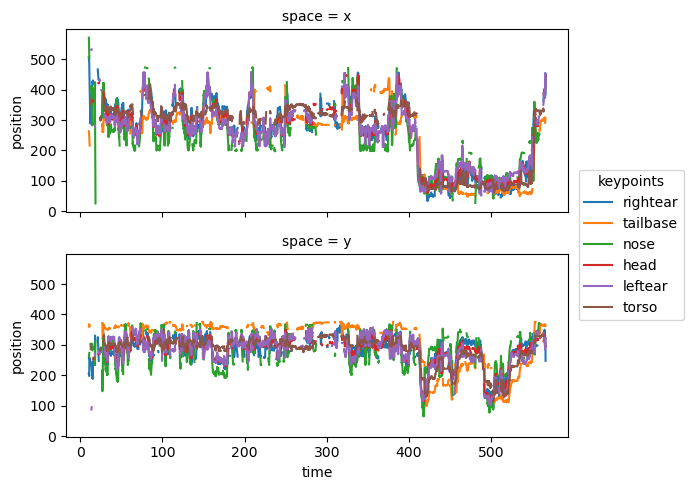

In [11]:
da.plot.line(x="time", row="space", aspect=2, size=2.5)


In [ ]:
save_poses.to_sleap_analysis_file(ds, "/path/to/file.h5")


In [20]:
def plot_raw_and_smooth_timeseries_and_psd(
    ds_raw,
    ds_smooth,
    individual="individual_0",
    keypoint="head",
    space="x",
    time_range=None,
):
    # If no time range is specified, plot the entire time series
    if time_range is None:
        time_range = slice(0, ds_raw.time[-1])

    selection = {
        "time": time_range,
        "individuals": individual,
        "keypoints": keypoint,
        "space": space,
    }

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    for ds, color, label in zip(
        [ds_raw, ds_smooth], ["k", "r"], ["raw", "smooth"], strict=False
    ):
        # plot position time series
        pos = ds.position.sel(**selection)
        ax[0].plot(
            pos.time,
            pos,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

        # interpolate data to remove NaNs in the PSD calculation
        pos_interp = interpolate_over_time(
            pos, print_report=False, fill_value="extrapolate"
        )

        # compute and plot the PSD
        freq, psd = welch(pos_interp, fs=ds.fps, nperseg=256)
        ax[1].semilogy(
            freq,
            psd,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

    ax[0].set_ylabel(f"{space} position (px)")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Time Domain")
    ax[0].legend()

    ax[1].set_ylabel("PSD (px$^2$/Hz)")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_title("Frequency Domain")
    ax[1].legend()

    plt.tight_layout()
    fig.show()

In [21]:
window = int(0.1 * ds_mouse.fps)
ds_mouse_smooth = ds_mouse.copy()
ds_mouse_smooth.update({"position": median_filter(ds_mouse.position, window)})


Missing points (marked as NaN) in input
	Individual: individual_0
		rightear: 1672/18412 (9.1%)
		tailbase: 1818/18412 (9.9%)
		nose: 4356/18412 (23.7%)
		head: 1773/18412 (9.6%)
		leftear: 1493/18412 (8.1%)
		torso: 1876/18412 (10.2%)

Missing points (marked as NaN) in output
	Individual: individual_0
		rightear: 1708/18412 (9.3%)
		tailbase: 1850/18412 (10.0%)
		nose: 4450/18412 (24.2%)
		head: 1804/18412 (9.8%)
		leftear: 1527/18412 (8.3%)
		torso: 1914/18412 (10.4%)


<xarray.Dataset> Size: 2MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, keypoints, individuals, space) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
    speed        (time, keypoints, individuals) float32 442kB 0.3205 ... 181.4
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses

In [22]:
from matplotlib import pyplot as plt
from scipy.signal import welch

from movement import sample_data
from movement.filtering import (
    interpolate_over_time,
    median_filter,
    savgol_filter,
)

C:\Users\esay\AppData\Local\Temp\ipykernel_109056\4185758196.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


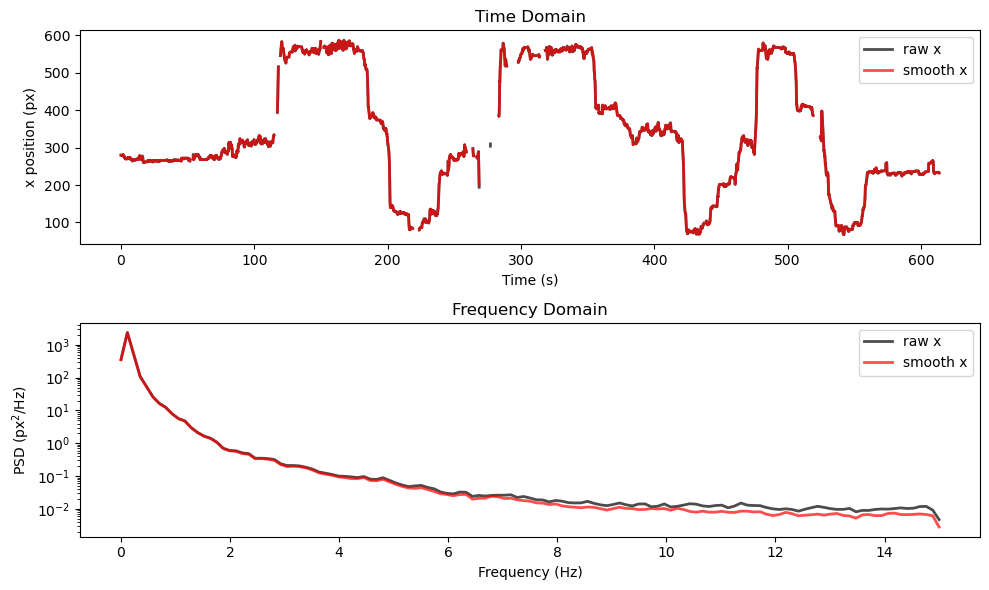

In [24]:
plot_raw_and_smooth_timeseries_and_psd(
    ds_mouse, ds_mouse_smooth, keypoint="head"
)

In [13]:
ds_mouse.keys()

KeysView(<xarray.Dataset> Size: 2MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, keypoints, individuals, space) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
    speed        (time, keypoints, individuals) float32 442kB 0.3205 ... 181.4
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses)